In [ ]:
# Przygotowanie srodowiska
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
# Deklaracja zmiennych
image_path = "szerszenie_uwb.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [ ]:
# Definiowanie funkcji pomocniczych
def preprocess_image(image_path): # Ładuje obraz ze ścieżki i wstępnie przetworzony, aby przygotować model
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Zapisano jako %s.jpg" % filename)
%matplotlib inline
def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
hr_image = preprocess_image(image_path)

In [ ]:
# Zapisanie oryginalnego obrazu
save_image(tf.squeeze(hr_image), filename="Original Image")

Zapisano jako Original Image.jpg


In [ ]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Czas wykonania: %f" % (time.time() - start))

Czas wykonania: 12.435046


In [ ]:
# Zapisanie przetworzonego obrazu (super rozdzielczość)
save_image(tf.squeeze(fake_image), filename="Super Resolution")

Zapisano jako Super Resolution.jpg


In [ ]:
# Definiowanie funkcji pomocniczych
def downscale_image(image):
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(image_path)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

In [ ]:
# Zapisanie obrazu o niskiej rozdzielczości
save_image(tf.squeeze(lr_image), filename="Low Resolution")

Zapisano jako Low Resolution.jpg


In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.503404


In [ ]:
# Obliczanie stosunku sygnału do szumu oryginalnego obrazu
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print(" Stosunek sygnału do szumu wyniosł: %f" % psnr)

 Stosunek sygnału do szumu wyniosł: 22.404131


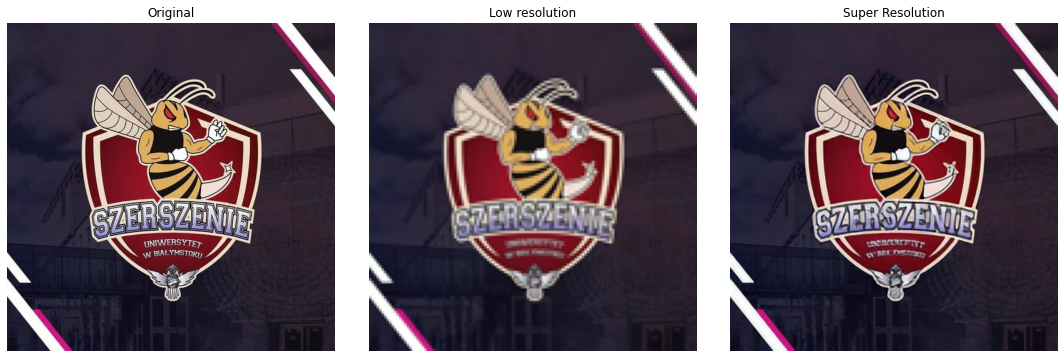

In [ ]:
#Porównanie rezultatów obok siebie
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "Low resolution")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("Subploted.jpg", bbox_inches="tight")